# Introduction
For this project, we are working for a metal refinery.  Our goal is to develop a model to estimate the recovery of gold from gold ore.

## Technological process
Mined ore passes through flotation and purification stages on its way to pure, concentrated gold.

1. _Flotation_:  Gold ore mixture ("rougher feed") is fed into float banks to obtain rougher Au concentrate and rougher tails (product residues with a low concentration of valuable metals).
2. _Purification_:  The rougher concentrate undergoes two stages of purification. After purification, we have the final concentrate and new tails.

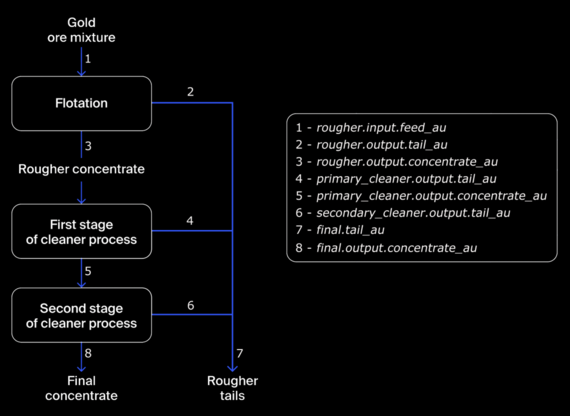

## Recovery calculation
Our model will produce two recovery estimates:  flotation ("rougher") recovery and final recovery.  Recovery is the ratio of output to input, i.e., mass of gold exiting the flotation or purification stage to the mass of gold entering the stage.  The recovery ratio is calculated from the measured concentrations of gold entering the and exiting the stage.  "Exiting" takes two forms:  concentrated gold and tails.

Recovery may be influenced by several factors:

1.  Raw material inputs, which include gold and other metals such as silver and lead.
2.  Feed rate
3.  Reagents added to the float banks
4.  Physical parameters of the stage, such as volume of air, particle size, and feed rate

Our model will predict recovery from these factors.

## Evaluation metric
Our model will minimize sMAPE, symmetric Mean Absolute Percentage Error.  sMAPE is similar to mean absolute percentage error (MAPE), but MAPE is biased in favor of lower predictions, while sMAPE treats lower and higher predictions the same.  Also, unlike MAPE, which is unbounded when the actual value is zero, sMAPE has both upper and lower bounds, ranging from 0% to 200%.

## Methodology
After a preliminary review of the data, we will perform exploratory data analysis, preprocessing, and model development.

1.  During the _exploratory data analysis_ phase, we will 
    - Examine how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
    - Compare the feed particle size distributions in the training and test sets.
    - Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate
    - Identify preprocessing requirements.


2.  During the _preprocessing_ phase, we will
    - Calculate recovery and compare the result to the values in the data set.
    - Identify features and targets.
    - Prepare test and training sets.


3.  During the _model development_ phase, we will
    - Develop models to predict recovery using several machine learning algorithms.
    - Select the algorithm that minimizes our evaluation metric, sMAPE.

# Preliminary Data Review
In this section, we will open the files and review the data.

In [1]:
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

In [2]:
warnings.filterwarnings('ignore')

random_state = 12345

try:
    df_test = pd.read_csv('gold_recovery_test.csv')
    df_train = pd.read_csv('gold_recovery_train.csv')
    df_full = pd.read_csv('gold_recovery_full.csv')
except:
    df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
    df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [4]:
#df_test.info()

In [5]:
df = pd.DataFrame(df_full.isna().mean()*100).sort_values(by=0, ascending=False).head(10)
df.columns = ['Percent Missing']
df

,Percent Missing
rougher.output.recovery,13.730410
rougher.output.tail_ag,12.048776
rougher.output.tail_au,12.044374
rougher.output.tail_sol,12.044374
rougher.input.floatbank11_xanthate,9.935728
secondary_cleaner.output.tail_sol,9.750836
final.output.recovery,8.641486
rougher.calculation.au_pb_ratio,7.162353
primary_cleaner.input.sulfate,7.083113
primary_cleaner.input.depressant,6.805776


## Conclusion (prelim review)
The full data set contains 22,716 entries.  Each entry represents gold acquisition at a different time.  About 14% of acquisitions have a missing value for <code>rougher.output.recovery</code>, one of the targets for our models.

The test data set contains 5,856 records, which represents about 26% of the total.  The test data set does not include potential targets, i.e., the concentrates and tails for gold and other materials.

# Exploratory Data Analysis
In this section, we will:

- Examine how how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
- Compare the feed particle size distributions in the training and test sets.
- Examine the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate.

We will also perform data preprocessing in this section, eliminating anomalies as they are identified.

## Metal concentration by stage

In [6]:
selected = [c for c in df_full.columns if ('ag' in c or 'au' in c or 'pb' in c) and ('calculation' not in c)]
df_stages = pd.DataFrame(df_full[selected].sum()/len(df_full)).reset_index()
df_stages.columns = ['param', 'mean_concentration']
df_stages['stage'] = df_stages['param'].apply(lambda p: '.'.join(p.split('.')[0:2]))
df_stages['metal'] = df_stages['param'].apply(lambda p: ''.join(p.rsplit('_', maxsplit=1)[1]))
df_stages['is_tail'] = df_stages['param'].apply(lambda p: True if 'tail' in p else False)
order = {'rougher.input':0, 
         'rougher.output':1,
         'primary_cleaner.output':2,
         'secondary_cleaner.output':3,
         'final.output':4}
df_stages['order'] = df_stages['stage'].apply(lambda s: order[s])
df_stages.sort_values(by=['order', 'metal', 'is_tail'], inplace=True)
df_stages = df_stages[['order', 'stage', 'is_tail', 'metal', 'mean_concentration']]
df_stages.head()

,order,stage,is_tail,metal,mean_concentration
12,0,rougher.input,False,ag,8.030919
14,0,rougher.input,False,au,7.532865
13,0,rougher.input,False,pb,3.270168
15,1,rougher.output,False,ag,10.827570
18,1,rougher.output,True,ag,4.914592


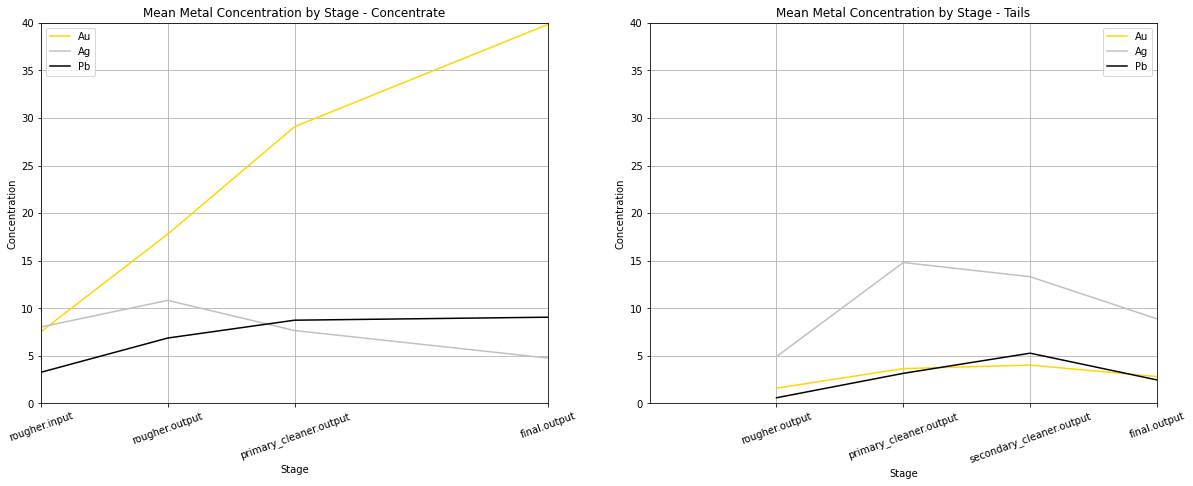

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# Concentrate
silver = df_stages.query('metal == "ag" and is_tail == False')[['order', 'stage','mean_concentration']].set_index('order')
gold = df_stages.query('metal == "au" and is_tail == False')[['order', 'stage','mean_concentration']].set_index('order')
lead = df_stages.query('metal == "pb" and is_tail == False')[['order', 'stage','mean_concentration']].set_index('order')

axs[0].set_title('Mean Metal Concentration by Stage - Concentrate')
axs[0].set_xlabel('Stage')
axs[0].set_ylabel('Concentration')
axs[0].set_xlim(0, 4)
axs[0].set_ylim(0, 40)
axs[0].set_xticks(gold.index)
axs[0].set_xticklabels(gold.stage, rotation=20)
axs[0].grid()
axs[0].plot(gold['mean_concentration'], color='gold', label='Au')
axs[0].plot(silver['mean_concentration'], color='silver', label='Ag')
axs[0].plot(lead['mean_concentration'], color='black', label='Pb')
axs[0].legend()

# Tails
silver = df_stages.query('metal == "ag" and is_tail == True')[['order', 'stage','mean_concentration']].set_index('order')
gold = df_stages.query('metal == "au" and is_tail == True')[['order', 'stage','mean_concentration']].set_index('order')
lead = df_stages.query('metal == "pb" and is_tail == True')[['order', 'stage','mean_concentration']].set_index('order')

axs[1].set_title('Mean Metal Concentration by Stage - Tails')
axs[1].set_xlabel('Stage')
axs[1].set_ylabel('Concentration')
axs[1].set_xlim(0, 4)
axs[1].set_ylim(0, 40)
axs[1].set_xticks(gold.index)
axs[1].set_xticklabels(gold.stage, rotation=20)
axs[1].grid()
axs[1].plot(gold['mean_concentration'], color='gold', label='Au')
axs[1].plot(silver['mean_concentration'], color='silver', label='Ag')
axs[1].plot(lead['mean_concentration'], color='black', label='Pb')
axs[1].legend()
plt.show()

The mean concentration of gold increases at each stage, which is, of course, the whole point.  The concentration of silver decreases after the rougher.output stage.

Although the mean concentration of gold follows the expected trend, increasing throughout the purification process, inspection of the concentration of gold for individual acquisitions reveals some deviations from the general tend.  For some acquisitions:

- There is no gold input.
- The concentration of gold actually _decreases_ during the purification process.

These anomalies may reflect measurement errors or actual problems with the process.  In either case, these anomalies are unlikely improve our predictive predictive model and will be removed.

### Elimination of acquisitions with decreasing gold concentration

In [8]:
missing_gold = []
for idx, row in df_full.iterrows():
    if (row['final.output.concentrate_au'] < row['primary_cleaner.output.concentrate_au']) or \
        (row['primary_cleaner.output.concentrate_au'] < row['rougher.output.concentrate_au']) or \
        (row['rougher.output.concentrate_au'] < row['rougher.input.feed_au']):
        missing_gold.append(idx)


df_full.drop(index=missing_gold, inplace=True)
print(f'{len(missing_gold)} rows with decreasing gold concentration dropped.')

1996 rows with decreasing gold concentration dropped.


### Elimination of acquisitions missing <code>rougher.input.feed_au</code>

In [9]:
missing_gold = df_full[(df_full['rougher.input.feed_au'].isna()) |
                       (df_full['rougher.input.feed_au'] == 0)].index
df_full.drop(index=missing_gold, inplace=True)
print(f'{len(missing_gold)} rows with no gold input dropped.')

1571 rows with no gold input dropped.


## Feed particle size
In this section, we will compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

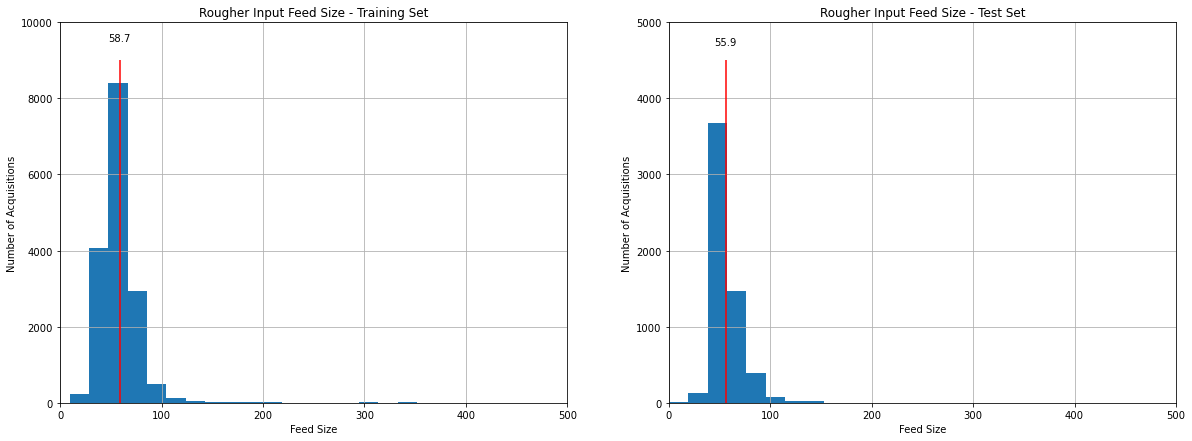

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

axs[0].hist(df_train['rougher.input.feed_size'], bins=25)
axs[0].set_title('Rougher Input Feed Size - Training Set')
axs[0].set_xlabel('Feed Size')
axs[0].set_ylabel('Number of Acquisitions')
axs[0].set_xlim(0, 500)
axs[0].set_ylim(0, 10000)
mean = df_train['rougher.input.feed_size'].mean()
axs[0].vlines(mean, 0, 9000, colors='red')
axs[0].text(mean, 9500, f'{mean:.1f}', horizontalalignment='center')
axs[0].grid()

axs[1].hist(df_test['rougher.input.feed_size'], bins=25)
axs[1].set_title('Rougher Input Feed Size - Test Set')
axs[1].set_xlabel('Feed Size')
axs[1].set_ylabel('Number of Acquisitions')
axs[1].set_xlim(0, 500)
axs[1].set_ylim(0, 5000)
mean = df_test['rougher.input.feed_size'].mean()
axs[1].vlines(mean, 0, 4500, colors='red')
axs[1].text(mean, 4700, f'{mean:.1f}', horizontalalignment='center')
axs[1].grid()

plt.show()

The input feed particle size distributions for the training and test sets are similar.

## Distributions of metals and solids in concentrate

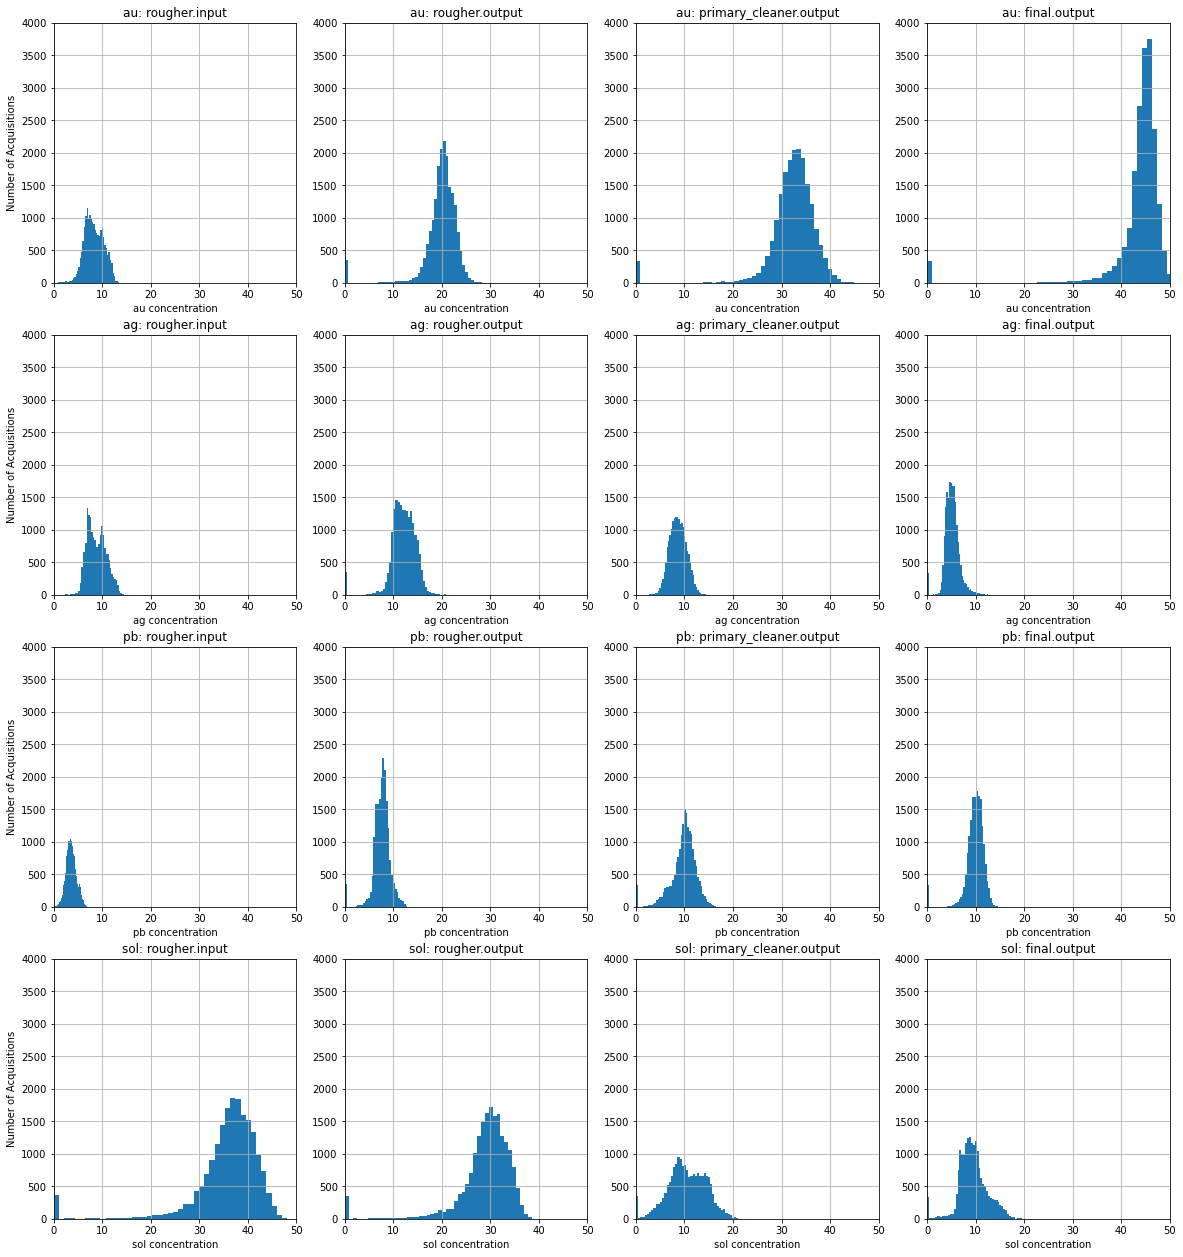

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(20, 22))
concentrate_cols = []

for i, substance in enumerate(['au', 'ag', 'pb', 'sol']):
    for j, stage in enumerate(['rougher.input.feed_','rougher.output.concentrate_', 
                               'primary_cleaner.output.concentrate_','final.output.concentrate_']):
        col = stage + substance
        concentrate_cols.append(col)
        
        axs[i, j].set_title('{}: {}'.format(substance, stage.rsplit('.', maxsplit=1)[0]))
        axs[i, j].hist(df_full[stage + substance], bins=50)
        axs[i, j].set_xlabel('{} concentration'.format(substance))
        if j == 0:
            axs[i, j].set_ylabel('Number of Acquisitions')
        axs[i, j].set_xlim(0, 50)
        axs[i, j].set_ylim(0, 4000)
        axs[i, j].grid()  

The distributions of metals and solid particles in the concentrate at various stages of the process all have roughly bell-shaped distributions, except that there are anomalous spikes near zero.  These spikes may represent measurement errors, but even if the data is valid, they are unlikely to enhance our predictive models.  We will replace the anomalies with the mean values.

### Elimination of anomalous concentrations

In [12]:
for c in concentrate_cols:
    mean = df_full[c].mean()
    df_full[c].mask(df_full[c] < 1, other=mean, inplace=True)

## Target-feature relationships for <code>rougher.output.recovery</code>
In this section we will create hexbin plots for showing the relationships between <code>rougher.output.recovery</code> and its associated features.

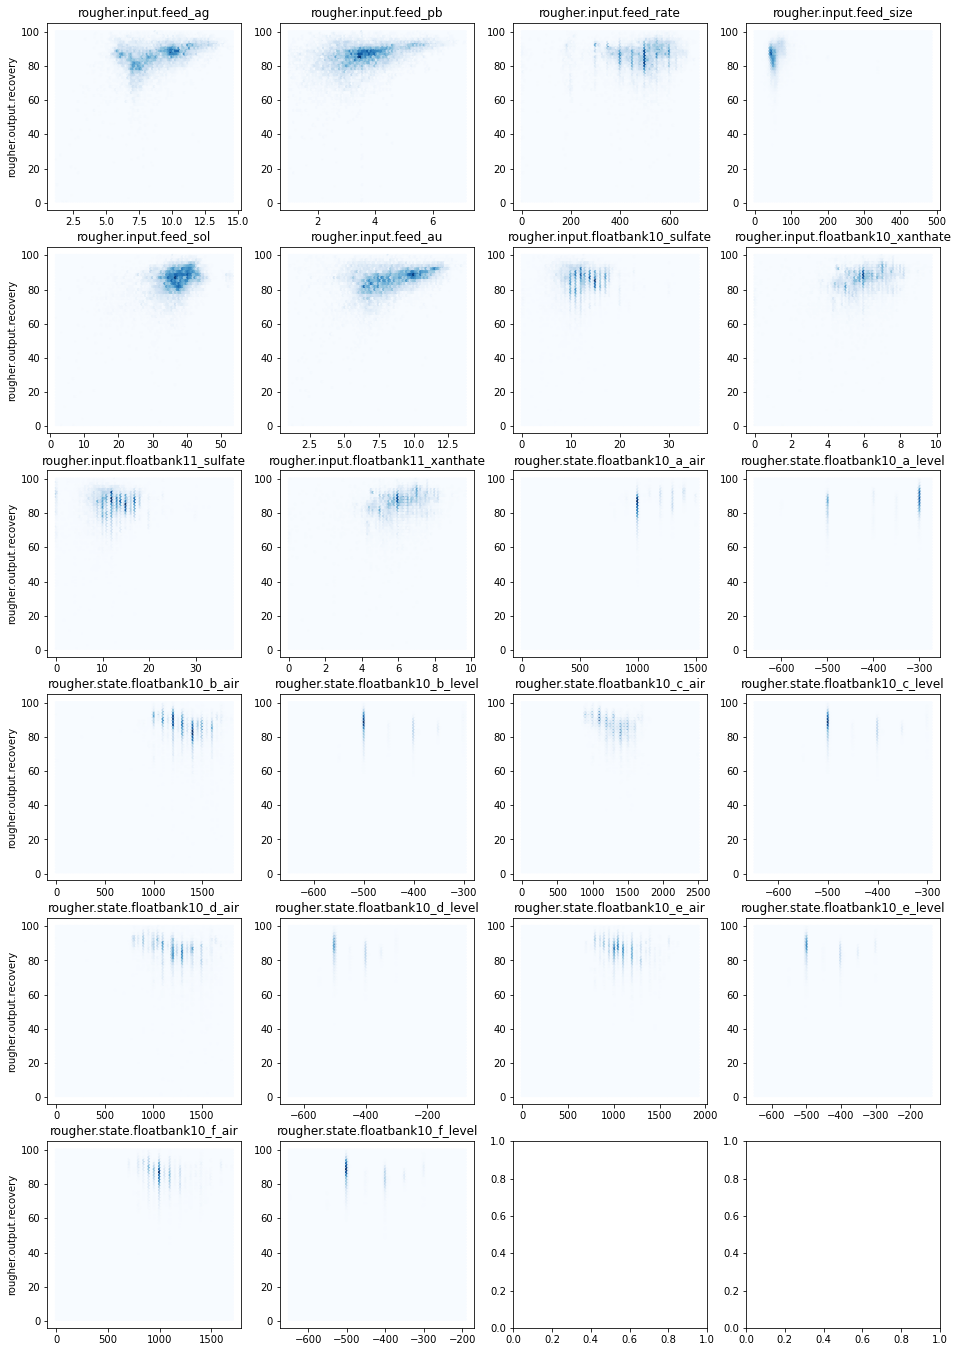

In [13]:
features = [col for col in df_test.columns if col.startswith('rougher')]
y = 'rougher.output.recovery'
NUM_COLS = 4
NUM_ROWS = int(len(features)/NUM_COLS)+1

fig, axs = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(16, 4*NUM_ROWS))

for ndx, name in enumerate(features):
    i = ndx//NUM_COLS
    j = ndx%NUM_COLS
    axs[i, j].set_title(f'{name}')
    axs[i, j].hexbin(df_full[name], df_full[y], cmap='Blues')
    if j == 0:
        axs[i, j].set_ylabel('rougher.output.recovery')

plt.show()

Most of the "signal" comes from the raw materials and reagents.  The air and fluid levels are the "noise", with widely dispersed values that bear no visual relationship to the target.

## Conclusion (EDA)
In this section, we performed exploratory data analysis and eliminated anomalies as they were identified.
- We examined the concentrations of metals and solids at various stages.  We noticed that the mean concentration of gold increases at each step of the process, as expected, but there are some acquisitions where there was no input gold or the concentration of gold actually decreased.  We eliminated these rows from the data set.
- We examined the feed particle size for the test and training sets and concluded that they are similar, so that models developed from the training set should also make accurate predictions for the test set.
-  We examined the distributions of metals and solids in the concentrate.  These distributions are generally bell-shaped, but we identified and replaced anomalous spikes near concentrations of zero.
- We created hexbin plots to examine the relationship between <code>rougher.output.recovery</code> and its related features.  We found that features related to air and fluid levels bear no visual relationship to the target.

# Preprocessing
We've already handled several preprocessing tasks in the previous section.  In this section, we will perform additional preprocessing steps.  We will:

- Check that recovery is calculated correctly and remove rows with missing recovery values.
- Eliminate rows with missing features.
- Handle outliers in features.

Finally, we will analyze the features that are not available in the test set, and we will  use this information to rebuild training and test sets from the full set, which has been modified during preproocessing.

## Recovery calculation
In this section, we will check that recovery is calculated correctly using the following function:

In [14]:
def calculate_recovery(row, C, F, T):
    numerator = row[C] * (row[F]-row[T])
    denominator = row[F] * (row[C]-row[T])
    if denominator == 0:
        return np.NaN
    return 100 * numerator / denominator

We will calculate recovery for <code>rougher.output.recovery</code> and <code>final.output.recovery</code> and compare the calculated results with the features in the data set.

### <code>rougher.output.recovery</code>

In [15]:
C = 'rougher.output.concentrate_au'
F = 'rougher.input.feed_au'
T = 'rougher.output.tail_au'

df_full['rougher.output.recovery_calculated'] = df_full.apply(calculate_recovery, C=C, F=F, T=T, axis=1)
df_recovery = df_full[['rougher.output.recovery', 'rougher.output.recovery_calculated']]
df_recovery.head()

,rougher.output.recovery,rougher.output.recovery_calculated
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


Our recovery calculation seems to agree with the features in the data set.  We will calculate the MAE to see if there are any discrepancies, but first, we have to deal with  missing values.

In [16]:
feature_out_of_range = len(df_full['rougher.output.recovery'] <= 0) + len(df_full['rougher.output.recovery'] > 100)
calculation_out_of_range = len(df_full['rougher.output.recovery_calculated'] <= 0) + len(df_full['rougher.output.recovery_calculated'] > 100)

missing_recovery = { 'rougher.output.recovery': 
                    [df_full['rougher.output.recovery'].isna().sum(),
                     feature_out_of_range],
                   'rougher.output.recovery_calculated':
                    [df_full['rougher.output.recovery'].isna().sum(),
                     calculation_out_of_range]}

pd.DataFrame(missing_recovery, index=['Missing', 'Out of range'])

,rougher.output.recovery,rougher.output.recovery_calculated
Missing,916,916
Out of range,38298,38298


We will drop records with missing values for <code>rougher.output.recovery</code> and proceed with MAE calculation.

In [17]:
df_full.dropna(subset=['rougher.output.recovery'], inplace=True)
df_full.reset_index(drop=True, inplace=True)

In [18]:
print('Mean absolute error: {}'.format(
    mean_absolute_error(df_full['rougher.output.recovery'],
                        df_full['rougher.output.recovery_calculated']))
     )

# Drop temporary column
df_full.drop(columns='rougher.output.recovery_calculated', inplace=True)

Mean absolute error: 0.011735210665116269


### <code>final.output.recovery</code>
Next we will repeat the previous steps for our other target.

In [19]:
C = 'final.output.concentrate_au'
F = 'rougher.input.feed_au'
T = 'final.output.tail_au'

df_full['final.output.recovery_calculated'] = df_full.apply(calculate_recovery, C=C, F=F, T=T, axis=1)
df_recovery = df_full[['final.output.recovery', 'final.output.recovery_calculated']]
df_recovery.head()

,final.output.recovery,final.output.recovery_calculated
0,70.541216,70.541216
1,69.266198,69.266198
2,68.116445,68.116445
3,68.347543,68.347543
4,66.927016,66.927016


In [20]:
feature_out_of_range = len(df_full['final.output.recovery'] <= 0) + len(df_full['final.output.recovery'] > 100)
calculation_out_of_range = len(df_full['final.output.recovery_calculated'] <= 0) + len(df_full['final.output.recovery_calculated'] > 100)

missing_recovery = { 'final.output.recovery': 
                    [df_full['final.output.recovery'].isna().sum(),
                     feature_out_of_range],
                   'final.output.recovery_calculated':
                    [df_full['final.output.recovery'].isna().sum(),
                     calculation_out_of_range]}

pd.DataFrame(missing_recovery, index=['Missing', 'Out of range'])

,final.output.recovery,final.output.recovery_calculated
Missing,31,31
Out of range,36466,36466


In [21]:
df_full.dropna(subset=['final.output.recovery'], inplace=True)
df_full.reset_index(drop=True, inplace=True)

In [22]:
print('Mean absolute error: {}'.format(
    mean_absolute_error(df_full['final.output.recovery'],
                        df_full['final.output.recovery_calculated']))
     )

df_full.drop(columns='final.output.recovery_calculated', inplace=True)

Mean absolute error: 0.006475178463761509


## Elimination of rows with missing features
We will drop rows with missing features.  (We previously tried replacing the missing features with means, but this worsened sMAPE downstream.)

In [23]:
print(f'Number of rows remaining in full data set: {df_full.shape[0]}')
print('')
print('Number of rows with missing features (top 10): ')
df_full[df_test.columns].isna().sum().sort_values(ascending=False).head(10)

Number of rows remaining in full data set: 18202

Number of rows with missing features (top 10): 


rougher.input.floatbank11_xanthate          381
rougher.state.floatbank10_e_air             351
secondary_cleaner.state.floatbank2_a_air    199
rougher.input.feed_size                     132
primary_cleaner.input.xanthate               83
rougher.input.feed_sol                       73
rougher.input.feed_pb                        66
rougher.input.floatbank11_sulfate            30
rougher.input.floatbank10_sulfate            23
primary_cleaner.input.depressant             17
dtype: int64

In [24]:
#df_full[df_test.columns] = df_full[df_test.columns].fillna(value=df_full[df_test.columns].mean())
df_full.dropna(subset=df_test.columns, inplace=True)
df.reset_index(drop=True, inplace=True)
print(f'Number of rows remaining in full data set: {df_full.shape[0]}')

Number of rows remaining in full data set: 16923


## Handling outliers in features
The test data set includes 52 features.  Most are related to air and fluid levels at various stages of the process.  A preliminary review of the distributions of these features (not shown here) suggests that there are many outliers.  In this section, we will replace outliers among the features with median values.

In [25]:
Q1 = df_full[df_test.columns].quantile(0.25)
Q2 = df_full[df_test.columns].quantile(0.5)
Q3 = df_full[df_test.columns].quantile(0.75)
IQR = Q3-Q1
low = Q1-1.5*IQR
high = Q3+1.5*IQR

outliers_low = df_full[df_test.columns] < low
df_full[df_test.columns] = df_full[df_test.columns].mask(outliers_low, Q2, axis=1)

outliers_high = df_full[df_test.columns] > high
df_full[df_test.columns] = df_full[df_test.columns].mask(outliers_high, Q2, axis=1)

#df_full.head()

## Training and test data sets

In [26]:
print('Potential targets, which are in the full set but not the training set:')
set(df_full.columns)-set(df_test.columns)

Potential targets, which are in the full set but not the training set:


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

The test set omits potential target variables.  In particular, it omits the recovery rate from each stage of the process and other factors that would be used to calculate recovery, such as the output concentrations and tails of gold and other metals.  By comparing the test data set to the full data set, we can infer which columns are appropriate for use as features and which must be used as targets, if used at all.  Of course, in order to test our model, we will have to restore the targets to the test set.

In earlier preprocessing steps, we dropped rows from the full data set.  We need to re-create the training and test data sets from the full data set to reflect these changes.  We will use the <code>date</code> field as a key identify records in the original test set that survived preprocessing and remain in the full set.  We will create test separate test sets for <code>rougher.output.recovery</code> and <code>final.output.recovery</code>.

In [27]:
# date in test set is key to match test records in full set.
test_acquisitions = df_test['date'].values 

# The columns in the test set (except the initial date column) indicate features.
all_features = list(df_test.columns[1:])

# Rougher features start with "rougher".
rougher_features = [f for f in all_features if f.startswith('rougher')]

# Create training sets with appropriate targets.
df_train_new = df_full.query('date not in @test_acquisitions')
df_train_rougher = df_train_new[rougher_features + ['rougher.output.recovery']]
df_train_final = df_train_new[all_features + ['final.output.recovery']]

# Create test sets with appropriate targets.
df_test_new = df_full.query('date in @test_acquisitions')
df_test_rougher = df_test_new[rougher_features + ['rougher.output.recovery']]
df_test_final = df_test_new[all_features + ['final.output.recovery']]

In [28]:
rows_count = ['df_test', 'df_test_rougher', 'df_test_final', 'df_train', 'df_train_rougher', 'df_train_final']
col_count = {'Rows' : [df_test.shape[0], df_test_rougher.shape[0], df_test_final.shape[0], df_train.shape[0], 
                       df_train_rougher.shape[0], df_train_final.shape[0]],
             'Cols' : [df_test.shape[1], df_test_rougher.shape[1], df_test_final.shape[1], df_train.shape[1], 
                       df_train_rougher.shape[1], df_train_final.shape[1]]
            }
pd.DataFrame(col_count, index=rows_count)

,Rows,Cols
df_test,5856,53
df_test_rougher,4931,23
df_test_final,4931,53
df_train,16860,87
df_train_rougher,11992,23
df_train_final,11992,53


The table above indicates how many records from the original test and training sets survived preprocessing.

## Conclusion (preprocessing)
In this section, we wrote a formula to calculate recovery and confirmed its correctness by comparing calculated recovery with the targets in the data set.  We eliminated rows with missing recovery target values and then calculated the MAE between our calculations and the corresponding targets.  MAE was low, 0.011 or less.

To further prepare our data set for regression, we removed rows with missing features and replaced outliers among features.  Finally, we reconstructed our test and training sets to reflect changes that were made during preprocessing.

# Model Development
In this section, we will develop regression models for both of our targets, <code>rougher.output.recovery</code> and <code>final.output.recovery</code>.  We will tune the models and select the models that minimize symmetric Mean Absolute Percentage Error (sMAPE).

## Evaluation metrics

In [29]:
#def smape(y, y_hat):
#    return sum([abs(obs-fit)/((abs(obs)+abs(fit))/2) for obs, fit in list(zip(y, y_hat))])*100/len(y)

def smape(y, y_hat):
    return 100/len(y) * np.sum(2 * np.abs(y_hat - y) / (np.abs(y) + np.abs(y_hat)))

def final_smape(rougher_smape, final_smape):
    return 0.25*rougher_smape + 0.75*final_smape

# For use with GridSearchCV
smape_scorer = make_scorer(smape, greater_is_better=False)

We will save the sMAPE's for our models in a dictionary.

In [30]:
results_table = {}

## Dummy model

### <code>rougher.output.recovery</code>
To predict <code>rougher.output.recovery</code>, we will limit our features to those that affect that step of the process, i.e., input materials, input parameters, reagents, and the  physical conditions in the floatbanks for the flotation stage.

In [31]:
# Target
y = 'rougher.output.recovery'
y_train = df_train_rougher[y]
y_test = df_test_rougher[y]
y_train.head()

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

In [32]:
# Features
X_train = df_train_rougher.loc[:, df_train_rougher.columns != y]
X_test = df_test_rougher.loc[:, df_test_rougher.columns != y]
X_train.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,999.940915,-451.939636
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,999.940915,-450.119001
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,999.940915,-450.527147
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,999.940915,-449.790835
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,10.960521,6.194897,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,999.940915,-450.407128


In [33]:
# Model
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_hat = dummy.predict(X_test)

In [34]:
# Metric
smape_dummy_rougher = smape(y_test, y_hat)
smape_dummy_rougher

5.150853866776401

### <code>final.output.recovery</code>

In [35]:
# Target
y = 'final.output.recovery'
y_train = df_train_final[y]
y_test = df_test_final[y]
y_train.head()

0    70.541216
1    69.266198
2    68.116445
3    68.347543
4    66.927016
Name: final.output.recovery, dtype: float64

In [36]:
# Features
X_train = df_train_final.loc[:, df_train_final.columns != y]
X_test = df_test_final.loc[:, df_test_final.columns != y]
X_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-499.952005,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-500.051946
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-499.849657,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-500.051946
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-500.051946
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-500.051946
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-500.051946


In [37]:
# Model
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_hat = dummy.predict(X_test)

In [38]:
# Metric
smape_dummy_final = smape(y_test, y_hat)
smape_dummy_final

8.211382489826708

### Final sMAPE

In [39]:
total_smape_dummy = final_smape(smape_dummy_rougher, smape_dummy_final)
total_smape_dummy

7.446250334064131

In [40]:
# Save results
results_table['Dummy'] = {'rougher' : smape_dummy_rougher,
                          'final' : smape_dummy_final,
                          'total' : total_smape_dummy}

## Linear regression

### <code>rougher.output.recovery</code>

In [41]:
# Target
y = 'rougher.output.recovery'
y_train = df_train_rougher[y]
y_test = df_test_rougher[y]

In [42]:
# Features
X_train = df_train_rougher.loc[:, df_train_rougher.columns != y]
X_test = df_test_rougher.loc[:, df_train_rougher.columns != y]

Our initial linear regression model will use all features.

In [43]:
# Full model
lm = LinearRegression()
lm.fit(X_train, y_train)
y_hat = lm.predict(X_test)

In [44]:
smape(y_test, y_hat)

4.390846402429894

The sMAPE for our initial linear regression model, using all features, is 4.4, which is better than the dummy model.  Next, we will try to simplify the model by selecting a subset of features for regression.

In [45]:
# Create a cross-validation scheme
folds = KFold(n_splits=5, shuffle=True, random_state=random_state)

# Hyperparameter selection: Specify range of number of features to include
params = [{'n_features_to_select': list(range(1, len(X_train.columns)+1))}]

# Specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)   

# Perform grid search
model_cv = GridSearchCV(estimator=rfe, 
                        param_grid=params, 
                        scoring=smape_scorer, 
                        cv=folds, 
                        verbose=1,
                        return_train_score=True)

# Fit the model
model_cv.fit(X_train, y_train)   

Fitting 5 folds for each of 22 candidates, totalling 110 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22]}],
             return_train_score=True,
             scoring=make_scorer(smape, greater_is_better=False), verbose=1)

In [46]:
# CV results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.028890,0.004442,0.001154,0.000039,1,{'n_features_to_select': 1},-6.812794,-6.766892,-6.792742,-6.933709,...,-6.760048,0.144763,22,-6.750548,-6.747682,-6.745065,-6.717796,-6.836545,-6.759527,0.040257
1,0.026564,0.001925,0.001513,0.000803,2,{'n_features_to_select': 2},-6.734784,-6.693878,-6.725009,-6.856927,...,-6.692252,0.132942,21,-6.687204,-6.680430,-6.677537,-6.651649,-6.758626,-6.691089,0.035858
2,0.024904,0.001696,0.001092,0.000007,3,{'n_features_to_select': 3},-5.945927,-5.873236,-6.020226,-6.026119,...,-5.891102,0.160555,20,-5.878680,-5.888353,-5.857929,-5.858243,-5.968875,-5.890416,0.040959
3,0.024122,0.002887,0.001095,0.000018,4,{'n_features_to_select': 4},-5.795771,-5.710959,-5.816182,-5.863411,...,-5.716076,0.168405,19,-5.698407,-5.709605,-5.689850,-5.678523,-5.798000,-5.714877,0.042794
4,0.023476,0.000916,0.001335,0.000471,5,{'n_features_to_select': 5},-5.601202,-5.562640,-5.577420,-5.701085,...,-5.571188,0.092437,18,-5.518082,-5.520983,-5.519216,-5.490243,-5.760487,-5.561802,0.099988


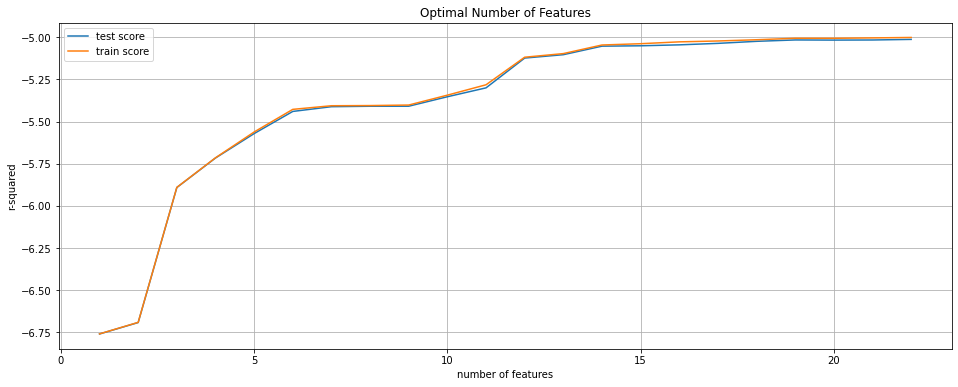

In [47]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
plt.grid()
plt.show()

We performed a grid search using recursive feature elimination to determine how many features can be safely eliminated from the full model.  From the plot above, it appears that we can eliminate 4 features, using 18 of the original 22.

In [48]:
# Final model
n_features_optimal = 18

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

In [49]:
best_features = X_train.columns[rfe.support_]
best_features

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
       'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_b_level',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air'],
      dtype='object')

In [50]:
# Simplified model
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

In [51]:
model = LinearRegression()
model.fit(X_train_best, y_train)
y_hat = model.predict(X_test_best)

In [52]:
# Metric
smape_lr_rougher = smape(y_test, y_hat)
smape_lr_rougher

4.428598541013006

### <code>final.output.recovery</code>

<code>final.output.recovery</code> reflects the whole process, so we will include all features in our initial model.

In [53]:
# Target
y = 'final.output.recovery'
y_train = df_train_final[y]
y_test = df_test_final[y]

In [54]:
# Features
X_train = df_train_final.loc[:, df_train_final.columns != y]
X_test = df_test_final.loc[:, df_test_final.columns != y]

In [55]:
# Full model
model = LinearRegression()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

In [56]:
print(smape(y_test, y_hat))

7.741077192166952


This is slightly better than our dummy model.  Again, we will try to simplify the model by finding out how many features can be eliminated without significantly increasing sMAPE.

In [57]:
# Create a cross-validation scheme
folds = KFold(n_splits=5, shuffle=True, random_state=random_state)

# Hyperparameter selection: Specify range of number of features to include
params = [{'n_features_to_select': list(range(1, len(X_train.columns)+1))}]

# Specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)   

# Perform grid search
model_cv = GridSearchCV(estimator=rfe, 
                        param_grid=params, 
                        scoring=smape_scorer, 
                        cv=folds, 
                        verbose=1,
                        return_train_score=True)

# Fit the model
model_cv.fit(X_train, y_train)   

Fitting 5 folds for each of 52 candidates, totalling 260 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True,
             scoring=make_scorer(smape, greater_is_better=False), verbose=1)

In [58]:
# CV results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.131548,0.006878,0.001510,0.000492,1,{'n_features_to_select': 1},-8.889802,-8.733506,-8.820293,-9.249059,...,-8.932047,0.176324,52,-8.942051,-8.986900,-8.960159,-8.847010,-8.923565,-8.931937,0.047334
1,0.132980,0.011117,0.001497,0.000498,2,{'n_features_to_select': 2},-8.841285,-8.704393,-8.775741,-9.203064,...,-8.897866,0.175031,51,-8.912188,-8.948360,-8.926679,-8.814187,-8.876663,-8.895615,0.046928
2,0.128252,0.007061,0.001227,0.000014,3,{'n_features_to_select': 3},-8.120094,-8.026294,-8.124129,-8.380592,...,-8.183178,0.124668,48,-8.198257,-8.226550,-8.200237,-8.125321,-8.154675,-8.181008,0.036154
3,0.124231,0.003209,0.001238,0.000007,4,{'n_features_to_select': 4},-8.116590,-8.028333,-8.159283,-8.380722,...,-8.187774,0.120754,50,-8.200910,-8.231406,-8.198127,-8.130937,-8.161024,-8.184481,0.034858
4,0.126298,0.007065,0.001239,0.000011,5,{'n_features_to_select': 5},-8.100588,-8.036421,-8.168043,-8.377911,...,-8.187191,0.119418,49,-8.197205,-8.226421,-8.189080,-8.129639,-8.160261,-8.180521,0.033039


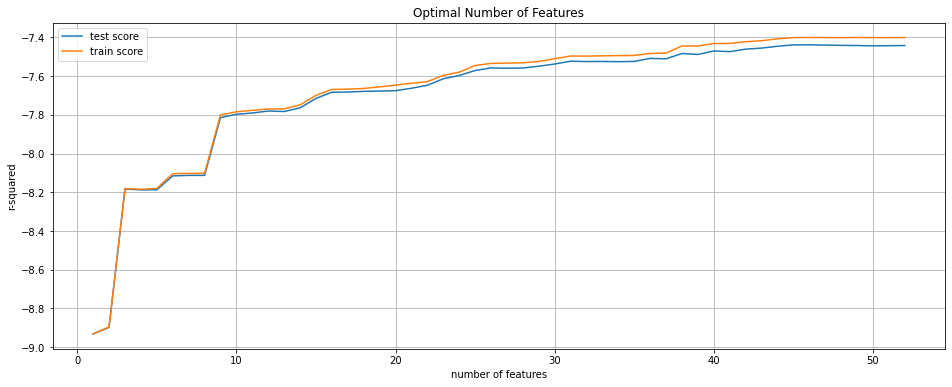

In [59]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
plt.grid()
plt.show()

We performed a grid search using recursive feature elimination to determine how many features can be safely eliminated from the full model.  From the plot above, it appears that we can eliminate 7 features, using 45 of the original 52.

In [60]:
# Final model
n_features_optimal = 52

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

In [61]:
best_features = X_train.columns[rfe.support_]
best_features

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

In [62]:
# Simplified model
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

In [63]:
model = LinearRegression()
model.fit(X_train_best, y_train)
y_hat = model.predict(X_test_best)

In [64]:
# Metric
smape_lr_final = smape(y_test, y_hat)
smape_lr_final

7.741077192166952

We achieved approximately the same sMAPE (7.7) using a subset of the original features.

### Final sMAPE

In [65]:
total_smape_lr = final_smape(smape_lr_rougher, smape_lr_final)
total_smape_lr

6.912957529378466

In [66]:
# Save results
results_table['Linear regression'] = {'rougher' : smape_lr_rougher,
                                      'final' : smape_lr_final,
                                      'total' : total_smape_lr}

## Random forest regression

### <code>rougher.output.recovery</code>

In [67]:
# Target
y = 'rougher.output.recovery'
y_train = df_train_rougher[y]
y_test = df_test_rougher[y]

In [68]:
# Features
X_train = df_train_rougher.loc[:, df_train_rougher.columns != y]
X_test = df_test_rougher.loc[:, df_test_rougher.columns != y]

In [69]:
# Hyperparameter selection
params = {'n_estimators': [40], 
          'max_depth': [5]}

In [70]:
forest = RandomForestRegressor(random_state=random_state)
regressor = GridSearchCV(estimator=forest, param_grid=params, cv=10, scoring=smape_scorer, verbose=False)
regressor.fit(X_train, y_train)
best_params = regressor.best_params_
best_params

{'max_depth': 5, 'n_estimators': 40}

In [71]:
# Model
best_forest = RandomForestRegressor(**best_params, random_state=random_state)
best_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 40,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

In [72]:
best_forest.fit(X_train, y_train)
y_hat = best_forest.predict(X_test)

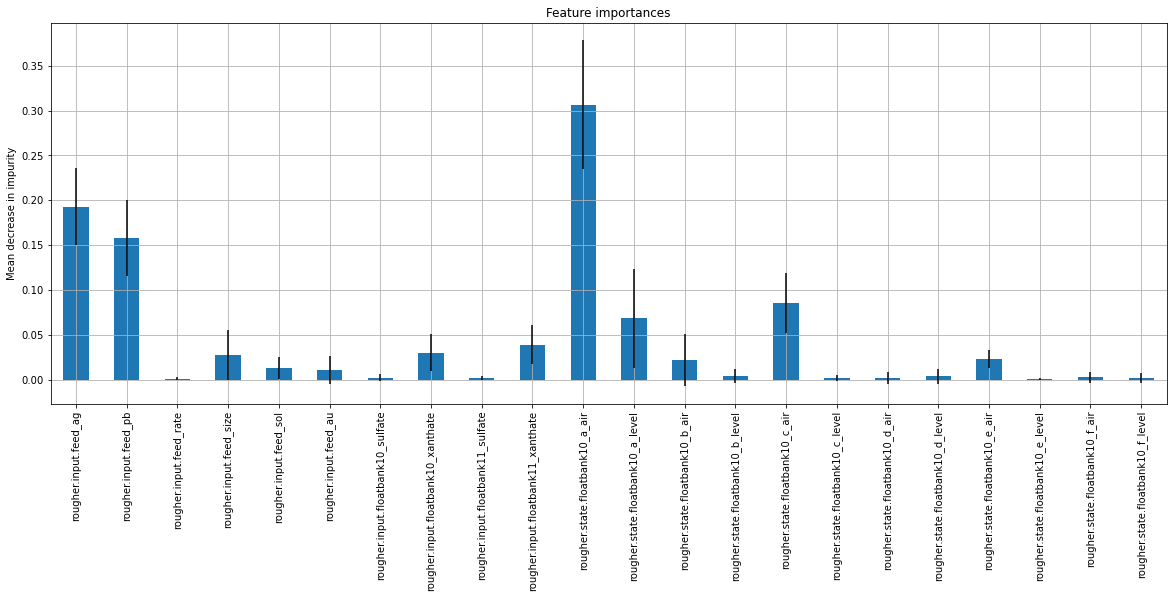

In [73]:
feature_names = X_train.columns
importances = best_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(20, 7))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.grid()
plt.show()

In [74]:
# Metric
smape_forest_rougher = smape(y_test, y_hat)
smape_forest_rougher

4.219636744046883

### <code>final.output.recovery</code>

In [75]:
# Target
y = 'final.output.recovery'
y_train = df_train_final[y]
y_test = df_test_final[y]

In [76]:
# Features
X_train = df_train_final.loc[:, df_train_final.columns != y]
X_test = df_test_final.loc[:, df_test_final.columns != y]

In [77]:
# Hyperparameter selection
params = {'n_estimators': [50], 
          'max_depth': [5]}

In [78]:
forest = RandomForestRegressor(random_state=random_state)
regressor = GridSearchCV(estimator=forest, param_grid=params, cv=10, scoring=smape_scorer, verbose=False)
regressor.fit(X_train, y_train)
best_params = regressor.best_params_
best_params

{'max_depth': 5, 'n_estimators': 50}

In [79]:
# Model
best_forest = RandomForestRegressor(**best_params, random_state=random_state)
best_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

In [80]:
best_forest.fit(X_train, y_train)
y_hat = best_forest.predict(X_test)

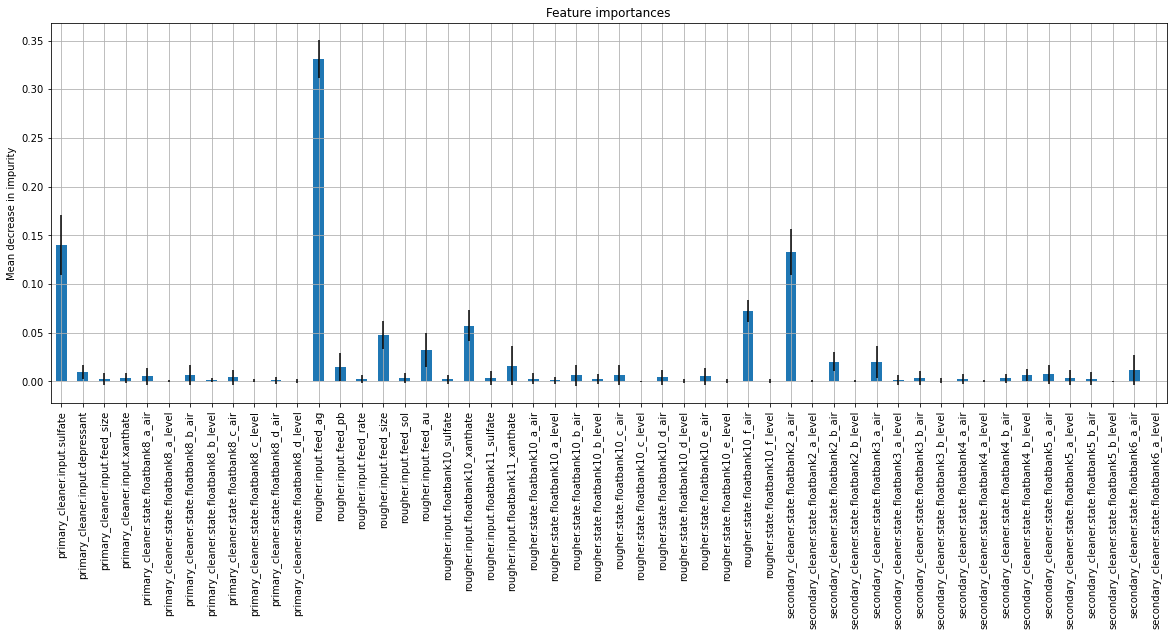

In [81]:
feature_names = X_train.columns
importances = best_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(20, 7))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.grid()
plt.show()

In [82]:
# Metric
smape_forest_final = smape(y_test, y_hat)
smape_forest_final

8.119878613561363

### Final sMAPE

In [83]:
total_smape_forest = final_smape(smape_forest_rougher, smape_forest_final)
total_smape_forest

7.144818146182744

In [84]:
# Save results
results_table['Random forest'] = {'rougher' : smape_forest_rougher,
                                  'final' : smape_forest_final,
                                  'total' : total_smape_forest}

## Conclusion (model development)

In [85]:
pd.DataFrame(results_table)

,Dummy,Linear regression,Random forest
rougher,5.150854,4.428599,4.219637
final,8.211382,7.741077,8.119879
total,7.446250,6.912958,7.144818


# Conclusion

In this project, we modeled the gold recovery rate for a refinery. After extensive data preprocessing, we developed linear regression and random forest models to predict the recovery rates for the initial step in the process (flotation) and for the overall recovery rate.

Both models outperformed the dummy model.  The linear regression model was the best, with a final symmetric mean absolute percentage error (sMAPE) of 6.9, compared to 7.4 for the dummy model.

In this project, our approach to modeling the final recovery rate drew a "black box" around the intermediate cleaning steps.  A more granular approach, in which each step of the process from flotation through both cleaning stages is individually modeled, might produce a more accurate result, at the cost of increased complexity.